In [145]:
import numpy as np
from scipy.io import wavfile
import os
import math
from tqdm import tqdm
from numba import jit, prange
from scipy.signal import get_window, windows
from scipy.fft import fft
import scipy.signal as signal
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
import re
import os

from enfify.enf_estimation import segmented_freq_estimation_DFT1, segmented_phase_estimation_hilbert
from enfify.preprocessing import downsample_ffmpeg, bandpass_filter, extract_number, cut_extract_number
from enfify.enf_enhancement import RFA, VMD

In [146]:
# ...........................RFA................................#

@jit(nopython=True, fastmath=True)
def z_SFM(sig, n, fs, alpha, tau):
    """Computes the z_SFM value with JIT optimization."""
    sum_sig = np.sum(sig[n - tau : n + tau + 1])
    z = np.exp(1j * 2 * np.pi * (1 / fs) * alpha * sum_sig)
    return z


@jit(nopython=True, parallel=True, fastmath=True)
def kernel_function(sig, f, n, fs, alpha, tau_values, tau_dash_values):
    """Computes the kernel function using JIT and vectorized operations."""
    auto_corr = np.empty(len(tau_values), dtype=np.complex128)
    auto_corr_dash = np.empty(len(tau_dash_values), dtype=np.complex128)

    for i in range(len(tau_values)):
        auto_corr[i] = z_SFM(sig, n, fs, alpha, tau_values[i])
        auto_corr_dash[i] = z_SFM(sig, n, fs, alpha, tau_dash_values[i])

    sin_vals = np.sin(2 * np.pi * (1 / fs) * f * tau_values)
    cos_vals = np.cos(2 * np.pi * (1 / fs) * f * tau_values)

    # Precompute exponents to save time in kernel calculation
    kernel = (auto_corr**sin_vals) * (auto_corr_dash**cos_vals)
    return np.angle(kernel)


@jit(nopython=True, parallel=True, fastmath=True)
def rfa_kernel_phases(sig, denoised_sig, Nx, f_start, fs, alpha, tau, tau_values, tau_dash_values):
    for n in prange(Nx - 1):
        f = f_start[n]
        kernel_phases = kernel_function(sig, f, n, fs, alpha, tau_values, tau_dash_values)
        denoised_sig[n] = np.sum(kernel_phases) / ((tau + 1) * tau * np.pi * alpha)

    return denoised_sig


def RFA(sig, fs, tau, epsilon, var_I, estimated_enf):
    """Optimized Recursive Frequency Adaptation algorithm with partial JIT optimization."""
    Nx = len(sig)
    alpha = 1 / (4 * fs * np.max(sig))
    f_start = estimated_enf * np.ones(Nx)
    tau_values = np.arange(1, tau + 1)
    tau_dash_values = tau_values + int(np.round(fs / (4 * estimated_enf)))

    for k in tqdm(range(var_I)):
        denoised_sig = np.zeros(Nx)

        denoised_sig = rfa_kernel_phases(
            sig, denoised_sig, Nx, f_start, fs, alpha, tau, tau_values, tau_dash_values
        )

        # Peak frequency estimation
        peak_freqs = segmented_freq_estimation_DFT1(
            denoised_sig, fs, num_cycles=5, N_DFT=40_000, nominal_enf=estimated_enf
        )

        plt.plot(peak_freqs)
        plt.xlabel("Cycles of nominal enf")
        plt.ylabel("Frequency Hz")
        plt.title("Frequency vs Time")
        plt.grid(True)
        plt.show()

        base_repeats = Nx // len(peak_freqs)
        remainder = Nx % len(peak_freqs)
        repeat_counts = np.full(len(peak_freqs), base_repeats)
        repeat_counts[:remainder] += 1
        new_freqs = np.repeat(peak_freqs, repeat_counts)

        f_diff = new_freqs - f_start
        f_start = new_freqs

        val = np.sum(f_diff**2) / np.sum(f_start**2)

        if val <= epsilon:
            return denoised_sig

        sig = denoised_sig  # Update the signal for the next iteration

    return denoised_sig



# ...................................Variational Mode Decomposition 2...................................#
def VMD_2(signal, alpha, tau, num_modes, enforce_DC, tolerance):
    """Variational Mode Decomposition (VMD)

    Args:
        signal (array): Input signal.
        alpha (float): Regularization parameter for the modes.
        tau (float): Time-step for dual ascent.
        num_modes (int): Number of modes to extract.
        enforce_DC (bool): Whether to enforce a DC component.
        tolerance (float): Convergence tolerance.

    Returns:
        modes (array): Decomposed modes.
        mode_spectra_final (array): Final mode spectra.
        final_freq_centers (array): Center frequencies of modes.
    """

    # Mirror signal at boundaries (optimized)
    signal_len = len(signal)
    midpoint = signal_len // 2
    if signal_len % 2:
        mirrored_signal = np.concatenate(
            [np.flipud(signal[:midpoint]), signal, np.flipud(signal[midpoint + 1 :])]
        )
    else:
        mirrored_signal = np.concatenate(
            [np.flipud(signal[:midpoint]), signal, np.flipud(signal[midpoint:])]
        )

    # Time and frequency domains
    total_length = len(mirrored_signal)
    time_domain = np.arange(total_length) / total_length
    spectral_domain = time_domain - 0.5

    # Precompute FFT of the mirrored signal
    signal_spectrum = np.fft.fftshift(np.fft.fft(mirrored_signal))
    positive_spectrum = np.zeros_like(signal_spectrum, dtype=complex)
    positive_spectrum[total_length // 2 :] = signal_spectrum[total_length // 2 :]

    # Mode and frequency center initialization
    max_iterations = 500
    mode_alphas = np.full(num_modes, alpha)
    freq_centers = np.zeros((max_iterations, num_modes))

    # Set initial frequency centers
    freq_centers[0, :] = 0.5 / num_modes * np.arange(num_modes)
    if enforce_DC:
        freq_centers[0, 0] = 0

    # Initialize dual variables and mode spectra
    dual_vars = np.zeros(total_length, dtype=complex)
    mode_spectra = np.zeros((max_iterations, total_length, num_modes), dtype=complex)

    # Iteration parameters
    convergence_criteria = tolerance + np.spacing(1)
    iteration_count = 0

    while convergence_criteria > tolerance and iteration_count < max_iterations - 1:
        mode_sum = np.sum(mode_spectra[iteration_count, :, :], axis=1)

        for mode in range(num_modes):
            residual = positive_spectrum - mode_sum + mode_spectra[iteration_count, :, mode]
            denom = (
                1
                + mode_alphas[mode] * (spectral_domain - freq_centers[iteration_count, mode]) ** 2
            )

            mode_spectra[iteration_count + 1, :, mode] = (residual - dual_vars / 2) / denom

            if mode == 0 and enforce_DC:
                freq_centers[iteration_count + 1, mode] = 0
            else:
                # Update frequency centers using the mode's positive frequencies
                mode_fft_half = mode_spectra[iteration_count + 1, total_length // 2 :, mode]
                freq_centers[iteration_count + 1, mode] = np.dot(
                    spectral_domain[total_length // 2 :], np.abs(mode_fft_half) ** 2
                ) / np.sum(np.abs(mode_fft_half) ** 2)

        # Dual ascent step
        dual_vars += tau * (
            np.sum(mode_spectra[iteration_count + 1, :, :], axis=1) - positive_spectrum
        )

        # Check for convergence
        convergence_criteria = np.linalg.norm(
            mode_spectra[iteration_count + 1, :, :] - mode_spectra[iteration_count, :, :],
            ord="fro",
        ) / np.linalg.norm(mode_spectra[iteration_count, :, :], ord="fro")
        iteration_count += 1

    # Extract the final results
    max_iterations = iteration_count
    final_freq_centers = freq_centers[:max_iterations, :]

    # Symmetrize the spectrum and reconstruct the signal modes
    final_mode_spectra = np.zeros((total_length, num_modes), dtype=complex)
    final_mode_spectra[total_length // 2 :, :] = mode_spectra[
        max_iterations - 1, total_length // 2 :, :
    ]

    # Handling even/odd length symmetry
    if total_length % 2 == 0:
        final_mode_spectra[:total_length // 2, :] = np.conj(final_mode_spectra[-1:total_length // 2-1:-1, :])
    else:
        final_mode_spectra[:total_length // 2, :] = np.conj(final_mode_spectra[-1:total_length // 2:-1, :])

    # Inverse FFT to obtain the modes
    modes = np.real(np.fft.ifft(np.fft.ifftshift(final_mode_spectra, axes=0), axis=0))

    # Trim the modes to the original signal length
    modes = modes[total_length // 4 : 3 * total_length // 4, :]

    # Compute the final spectra for the modes
    mode_spectra_final = np.fft.fftshift(np.fft.fft(modes, axis=0), axes=0)

    return modes.T, mode_spectra_final, final_freq_centers



In [147]:
# Estimate frequency with DFT¹ instantaneous estimation (Rodriguez Paper)
def freq_estimation_DFT1(s_tone, Fs, N_DFT):
    """_summary_

    Args:
        s_tone (_type_): _description_
        Fs (_type_): _description_
        N_DFT (_type_): _description_

    Returns:
        _type_: _description_
    """

    # ......Estimate the frequency......#
    window_type = "hamming"
    M = len(s_tone)

    # Get the window type
    window = get_window(window_type, M - 1)

    # Calculate the approx. first derivative of single tone
    s_tone_diff = Fs * np.diff(s_tone)
    s_tone = s_tone[1:]

    # Windowing
    s_tone_windowed = s_tone * window
    s_tone_diff_windowed = s_tone_diff * window

    # Zero-Padding of the signal
    s_tone_padded = np.pad(s_tone_windowed, (0, N_DFT - M), "constant")
    s_tone_padded_diff = np.pad(s_tone_diff_windowed, (0, N_DFT - M), "constant")

    # Calculate the DFT
    X = fft(s_tone_padded, n=N_DFT)
    X_diff = fft(s_tone_padded_diff, n=N_DFT)

    # Compute the amplitude spectrum and max. amplitude
    abs_X = np.abs(X)
    k_max = np.argmax(abs_X)
    abs_X_diff = np.abs(X_diff)

    # Estimated frequency of the single tone
    F_kmax = (np.pi * k_max) / (N_DFT * np.sin(np.pi * k_max / N_DFT))
    f0_estimated = (F_kmax * abs_X_diff[k_max]) / (2 * np.pi * abs_X[k_max])

    # Validate the frequency result
    k_DFT = (N_DFT * f0_estimated) / Fs
    try:
        k_DFT >= (k_max - 0.5) and k_DFT < (k_max + 0.5)
    except ValueError:
        print("estimated frequency is not valid")

    return f0_estimated


def segmented_freq_estimation_DFT1(s_in, f_s, num_cycles, N_DFT, nominal_enf):
    """_summary_

    Args:
        s_in (_type_): _description_
        f_s (_type_): _description_
        num_cycles (_type_): _description_
        N_DFT (_type_): _description_
        nominal_enf (_type_): _description_

    Returns:
        _type_: _description_
    """
    
    window_len = int(30)  # samples per nominal enf cycle
    step_size = int(15)

    segments = []
    for i in range(0, len(s_in), step_size):
        segments.append(s_in[i:i + window_len])
    segments = segments[:-1]

    freqs = []
    for i in range(len(segments)):
        freq = freq_estimation_DFT1(segments[i], f_s, N_DFT)
        freqs.append(freq)

    freqs = np.array(freqs)

    return freqs

In [148]:
# Audio Paths
UNCUT_PATH = (
    "/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/interim/Carioca1/authentic"
)
CUT_PATH = "/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/interim/Carioca1/tampered"

uncut_files = sorted(os.listdir(UNCUT_PATH))
uncut_files.sort(key=extract_number)
print(uncut_files)


cut_files = sorted(os.listdir(CUT_PATH))
cut_files.sort(key=cut_extract_number)
print(cut_files)

['HC1-00.wav', 'HC1-01.wav', 'HC1-02.wav', 'HC1-03.wav', 'HC1-04.wav', 'HC1-05.wav', 'HC1-06.wav', 'HC1-07.wav', 'HC1-08.wav', 'HC1-09.wav', 'HC10-00.wav', 'HC10-01.wav', 'HC10-02.wav', 'HC10-03.wav', 'HC10-04.wav', 'HC10-05.wav', 'HC10-06.wav', 'HC10-07.wav', 'HC10-08.wav', 'HC10-09.wav', 'HC11-00.wav', 'HC11-01.wav', 'HC11-02.wav', 'HC11-03.wav', 'HC11-04.wav', 'HC11-05.wav', 'HC11-06.wav', 'HC11-07.wav', 'HC11-08.wav', 'HC11-09.wav', 'HC12-00.wav', 'HC12-01.wav', 'HC12-02.wav', 'HC12-03.wav', 'HC12-04.wav', 'HC12-05.wav', 'HC12-06.wav', 'HC12-07.wav', 'HC12-08.wav', 'HC12-09.wav', 'HC13-00.wav', 'HC13-01.wav', 'HC13-02.wav', 'HC13-03.wav', 'HC13-04.wav', 'HC13-05.wav', 'HC13-06.wav', 'HC13-07.wav', 'HC13-08.wav', 'HC13-09.wav', 'HC14-00.wav', 'HC14-01.wav', 'HC14-02.wav', 'HC14-03.wav', 'HC14-04.wav', 'HC14-05.wav', 'HC14-06.wav', 'HC14-07.wav', 'HC14-08.wav', 'HC14-09.wav', 'HC15-00.wav', 'HC15-01.wav', 'HC15-02.wav', 'HC15-03.wav', 'HC15-04.wav', 'HC15-05.wav', 'HC15-06.wav', 'HC1

In [149]:
# Constants sig, lowcut, highcut, fs, order
DOWNSAMPLE_FS = 1000
BANDPASS_ORDER = 5
BNP_LOW = 99.5
BNP_HIGH = 100.5

ALPHA = 50_000  # Balancing parameter of the data-fidelity constraint
TAU = 0  # Noise-tolerance (no strict fidelity enforcement)
N_MODE = 1  # Number of modes to be recovered
DC = 0
TOL = 1e-7  # Tolerance of convergence criterion

F0 = 100
I = 1
EPSILON = 1e-7
TAU_RFA = int(750)

N_DFT = 20_000
NUM_CYCLES = 5

k = 3

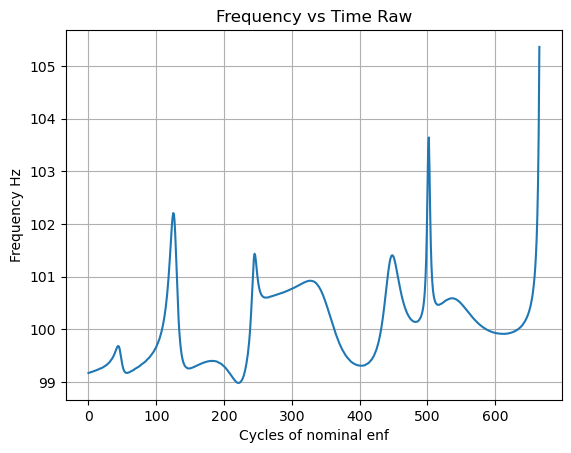

100%|██████████| 1/1 [00:00<00:00, 61.82it/s]


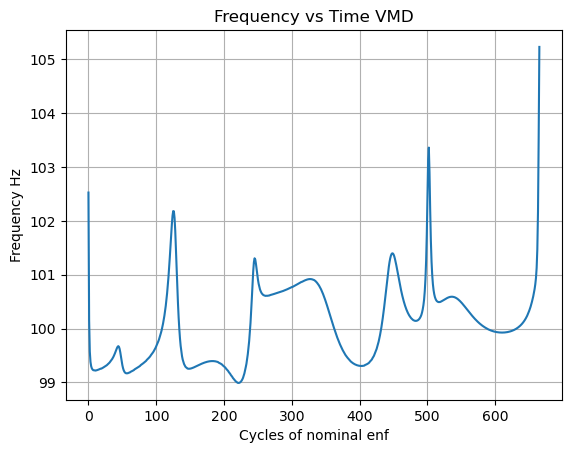

  0%|          | 0/1 [00:00<?, ?it/s]

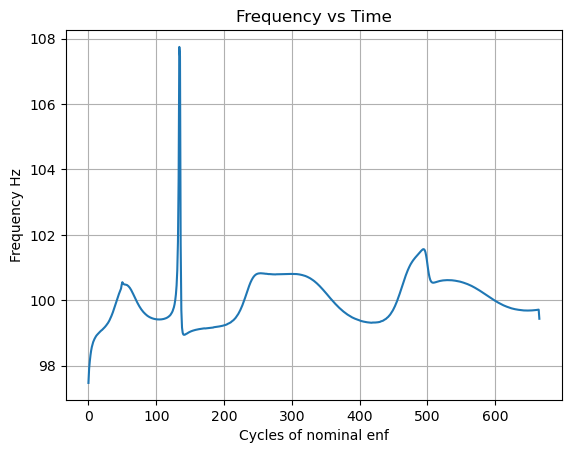

100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


In [150]:
## ENF Preprocessing and enhancement
# Read
pth = os.path.join(UNCUT_PATH, uncut_files[k])
sample_rate, data = wavfile.read(pth)

# Downsampling
down_sig, down_fs = downsample_ffmpeg(data, sample_rate, DOWNSAMPLE_FS)

# Bandpass
band_sig = bandpass_filter(down_sig, BNP_LOW, BNP_HIGH, DOWNSAMPLE_FS, BANDPASS_ORDER)

freqs = segmented_freq_estimation_DFT1(band_sig, DOWNSAMPLE_FS, NUM_CYCLES, N_DFT, F0)
plt.plot(freqs)
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Frequency Hz")
plt.title("Frequency vs Time Raw")
plt.grid(True)
plt.show()


# VMD
for i in tqdm(range(1)):
    u_clean, _, _ = VMD(band_sig, ALPHA, TAU, N_MODE, DC, TOL)
    vmd_sig = u_clean[0]

freqs = segmented_freq_estimation_DFT1(vmd_sig, DOWNSAMPLE_FS, NUM_CYCLES, N_DFT, F0)
plt.plot(freqs)
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Frequency Hz")
plt.title("Frequency vs Time VMD")
plt.grid(True)
plt.show()


# RFA
rfa_sig = RFA(vmd_sig, DOWNSAMPLE_FS, TAU_RFA, EPSILON, I, F0)

freqs = segmented_freq_estimation_DFT1(rfa_sig, DOWNSAMPLE_FS, NUM_CYCLES, N_DFT, F0)

phases = segmented_phase_estimation_hilbert(rfa_sig, DOWNSAMPLE_FS, NUM_CYCLES, F0)
phases = np.unwrap(phases)
x = np.arange(len(phases))

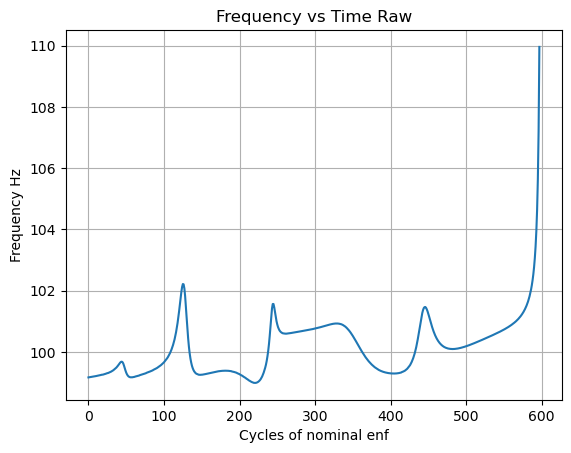

/tmp/ipykernel_294123/2132224101.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  convergence_criteria = np.linalg.norm(


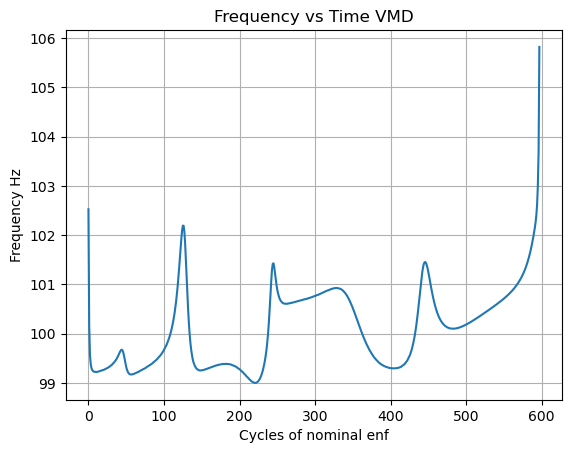

  0%|          | 0/1 [00:00<?, ?it/s]

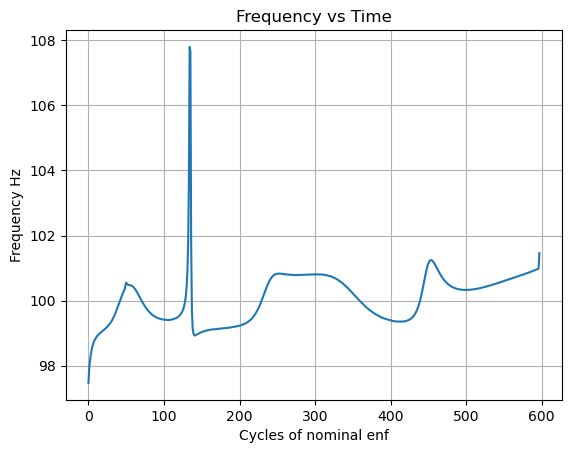

100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


In [151]:
## ENF Preprocessing and enhancement
# Read
pth = os.path.join(CUT_PATH, cut_files[k])
sample_rate, data = wavfile.read(pth)

# Downsampling
down_sig, down_fs = downsample_ffmpeg(data, sample_rate, DOWNSAMPLE_FS)

# Bandpass
band_sig = bandpass_filter(down_sig, BNP_LOW, BNP_HIGH, DOWNSAMPLE_FS, BANDPASS_ORDER)

freqs_cut = segmented_freq_estimation_DFT1(band_sig, DOWNSAMPLE_FS, NUM_CYCLES, N_DFT, F0)
plt.plot(freqs_cut)
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Frequency Hz")
plt.title("Frequency vs Time Raw")
plt.grid(True)
plt.show()


# VMD
for i in range(5):
    u_clean, _, _ = VMD_2(band_sig, ALPHA, TAU, N_MODE, DC, TOL)
    vmd_sig = u_clean[0]

freqs_cut = segmented_freq_estimation_DFT1(vmd_sig, DOWNSAMPLE_FS, NUM_CYCLES, N_DFT, F0)
plt.plot(freqs_cut)
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Frequency Hz")
plt.title("Frequency vs Time VMD")
plt.grid(True)
plt.show()


# RFA
rfa_sig = RFA(vmd_sig, DOWNSAMPLE_FS, TAU_RFA, EPSILON, I, F0)

freqs_cut = segmented_freq_estimation_DFT1(rfa_sig, DOWNSAMPLE_FS, NUM_CYCLES, N_DFT, F0)

phases_cut = segmented_phase_estimation_hilbert(rfa_sig, DOWNSAMPLE_FS, NUM_CYCLES, F0)
phases_cut = np.unwrap(phases_cut)
x_cut = np.arange(len(phases_cut))


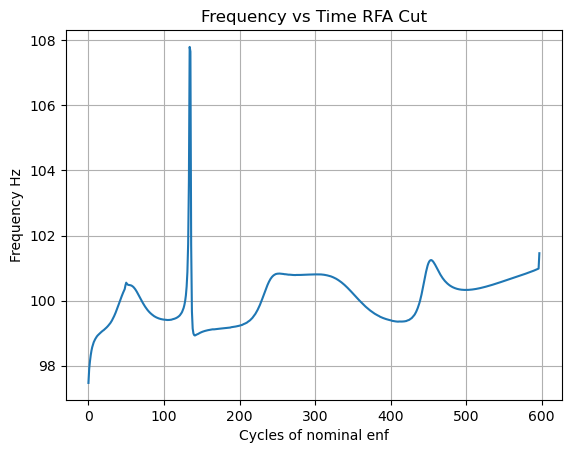

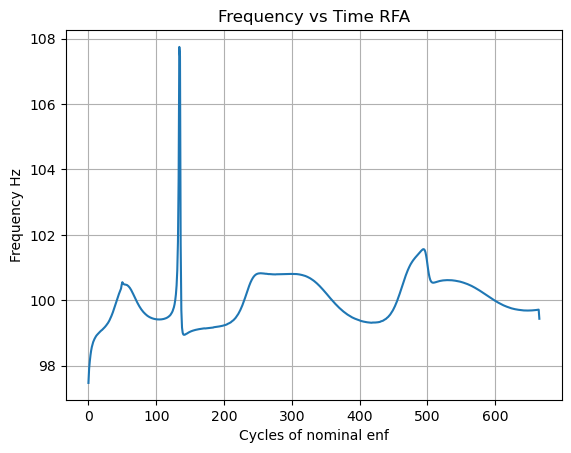

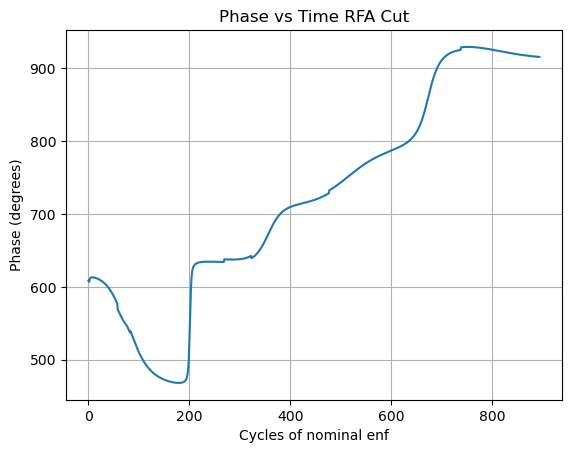

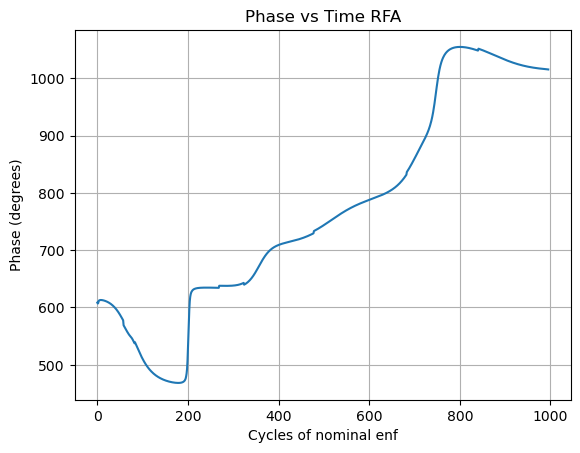

In [152]:
# CUT
plt.plot(freqs_cut)
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Frequency Hz")
plt.title("Frequency vs Time RFA Cut")
plt.grid(True)
plt.show()

# Uncut
plt.plot(freqs)
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Frequency Hz")
plt.title("Frequency vs Time RFA")
plt.grid(True)
plt.show()

# Cut
plt.plot(x_cut, np.degrees(phases_cut))
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time RFA Cut")
plt.grid(True)
plt.show()

# Uncut
plt.plot(x, np.degrees(phases))
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time RFA")
plt.grid(True)
plt.show()

In [153]:
import numpy as np

# Beispiel-Array
array = np.arange(100)  # Erstellen eines Beispielarrays von 0 bis 99

# Funktion zum Aufteilen des Arrays in Frames (letztes Frame kann kürzer sein)
def split_into_frames(arr, frame_length, step_size):
    frames = []
    for i in range(0, len(arr), step_size):
        frames.append(arr[i:i + frame_length])
    return frames

# Parameter: Frame-Länge und Schrittweite
frame_length = 30
step_size = 15

# Aufteilen des Arrays in Frames (letztes Frame kürzer, falls nötig)
frames = split_into_frames(array, frame_length, step_size)

frames = frames[:-1]

# Ausgabe der Frames
print(frames)


[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]), array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]), array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]), array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
       77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]), array([75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91,
       92, 93, 94, 95, 96, 97, 98, 99])]
